# RANSAC 실습

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

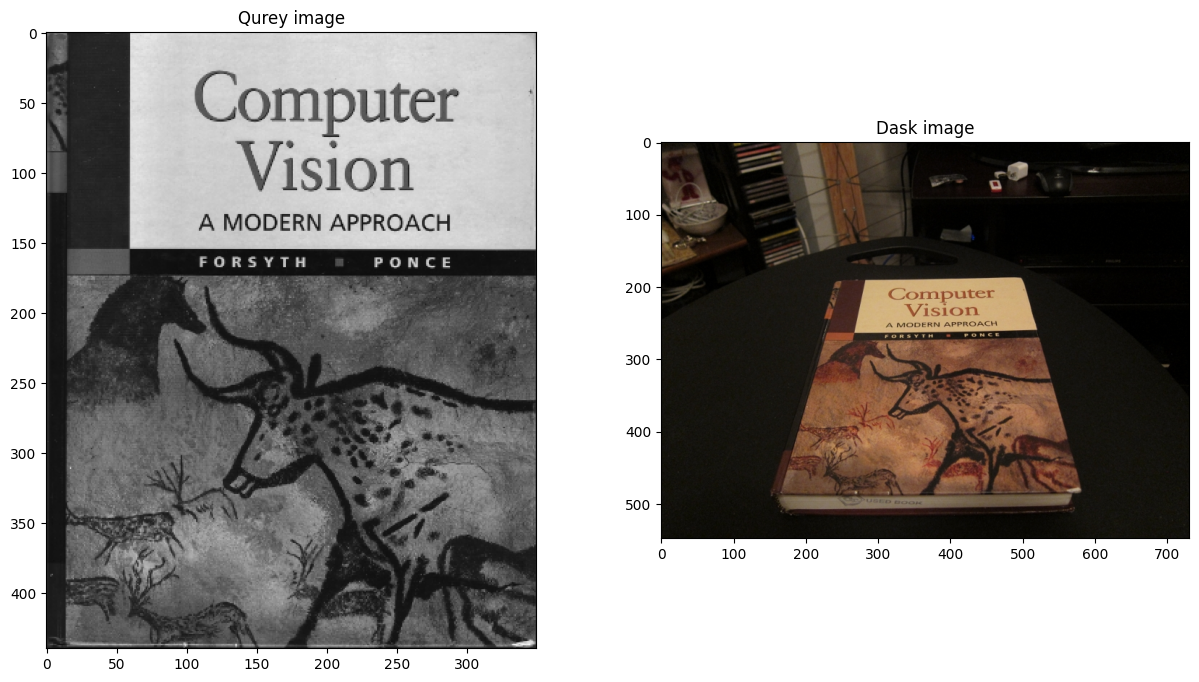

In [3]:
queryImage = '../chapter_2/Chapter_2.0/data/cv_cover.jpg'
trainImage = '../chapter_2/Chapter_2.0/data/cv_desk.png'

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(cv.imread(queryImage), cv.COLOR_BGR2RGB))
plt.title('Qurey image')
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(cv.imread(trainImage), cv.COLOR_BGR2RGB))
plt.title('Dask image')
plt.show()

img1 = cv.imread(queryImage, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(trainImage, cv.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)

# Match descriptors object
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key= lambda x:x.distance)

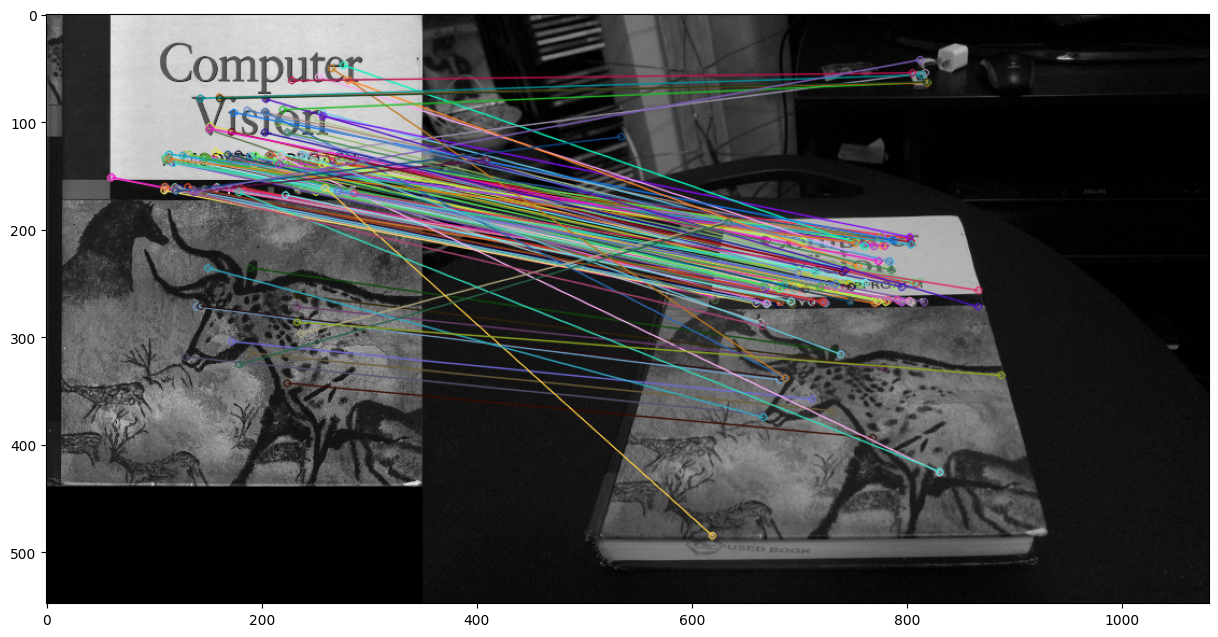

In [5]:
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

# Find homography and warping

In [13]:
# Extract location of good matches
points1 = np.zeros((len(matches),2), dtype=np.float32)
points2 = np.zeros((len(matches),2), dtype=np.float32)
for i, match in enumerate(matches): # enumerate: 열거하다.
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

h, mask = cv.findHomography(points1, points2, cv.RANSAC)

# print(h)
# print(np.array(matches).shape)
# print(mask.shape)

height, width = img2.shape

im1_wraped = cv.warpPerspective(img1, h, (width, height))

[[ 7.26561847e-01 -3.43595535e-01  2.38299920e+02]
 [-2.82391061e-02  2.29258465e-01  1.93738977e+02]
 [-5.71271121e-05 -9.05462166e-04  1.00000000e+00]]
(144,)
(144, 1)


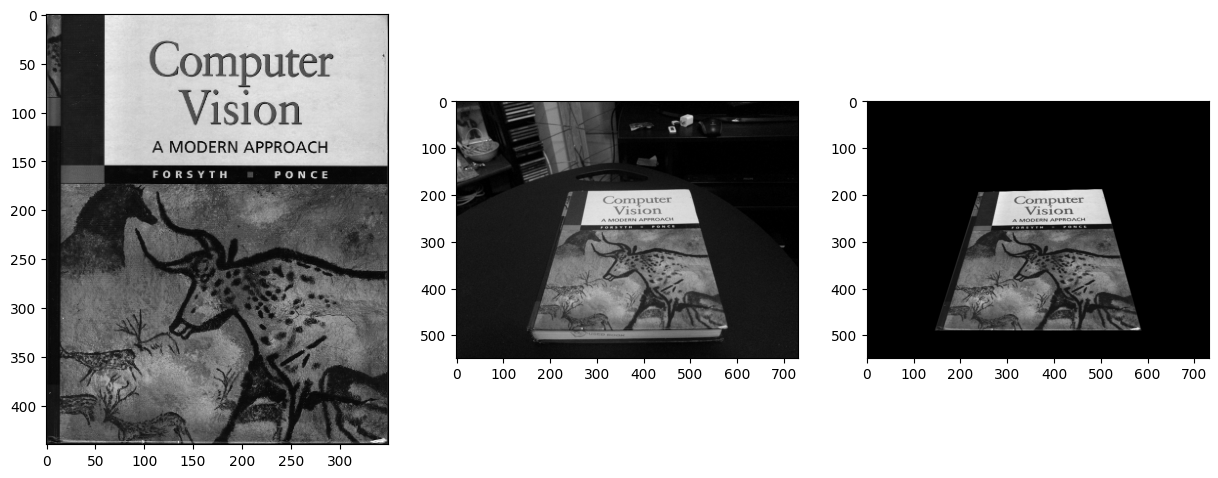

In [14]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im1_wraped, cmap='gray')

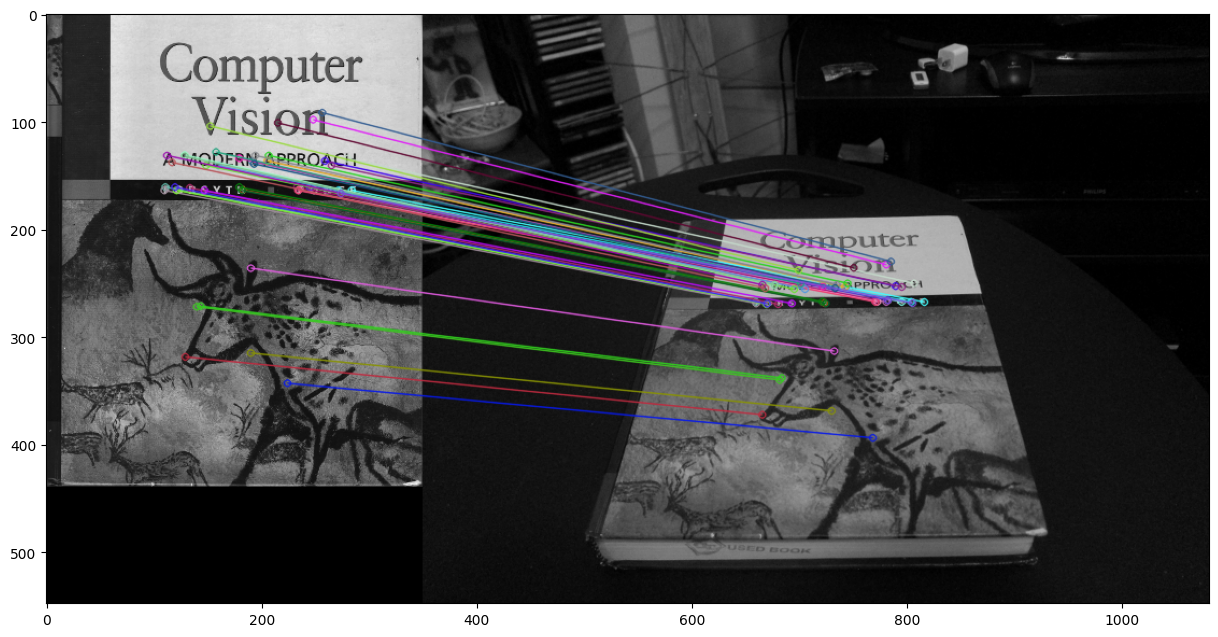

In [15]:
matches_opencv_ransac = np.array(matches)[np.nonzero(mask.squeeze())]
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches_opencv_ransac, None, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

# Using Kornia

tensor([[ 7.8175e-01, -3.8152e-01,  2.3554e+02],
        [ 7.2300e-03,  1.9523e-01,  1.9316e+02],
        [ 7.3941e-05, -1.0404e-03,  1.0000e+00]])
torch.Size([144]) (144, 2) (144, 2)


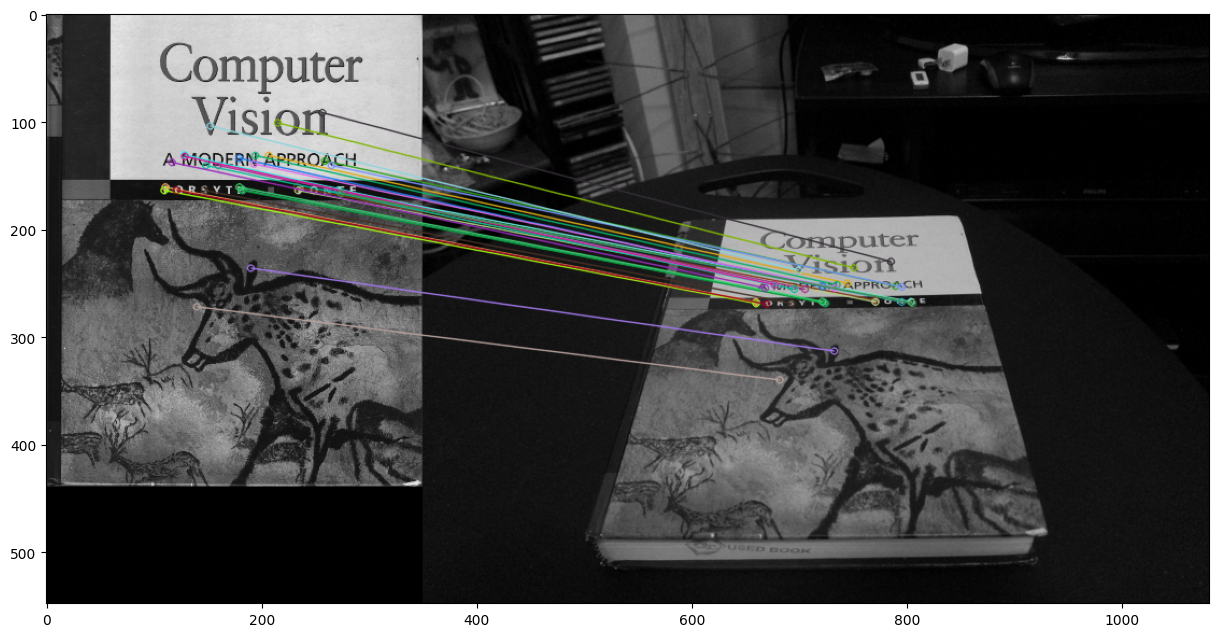

In [16]:
import torch
import kornia.geometry as KG
ransac = KG.ransac.RANSAC(model_type='homography')

# print(points1, points2, points1.shape)
H, inliers = ransac(torch.tensor(points1), torch.tensor(points2))

print(H)

print(inliers.shape, points1.shape, points2.shape)

matches_kornia = np.array(matches)[np.nonzero(inliers.squeeze())][:, 0]

img3 = cv.drawMatches(img1, kp1, img2, kp2, matches_kornia, None, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

In [17]:
ransac = KG.ransac.RANSAC(model_type='fundamental')
F, inliers = ransac(torch.tensor(points1), torch.tensor(points2))

print(F)

tensor([[-2.1416e-05,  5.5445e-04, -8.6892e-02],
        [-8.3637e-04,  4.2671e-05,  1.0265e-01],
        [ 2.3187e-01, -1.9393e-01,  1.0000e+00]])
